# 1. Introduction

#### 1.1 Business Problem

A machine learning model will be developed to predict the likelihood of individuals being diagnosed with diabetes based on specified features. Prior to commencing model development, essential steps in data analysis and feature engineering are anticipated to be undertaken.


#### 1.2 Dataset Story

The dataset is part of a large dataset maintained at the National Institute of Diabetes and Digestive and Kidney Diseases in the United States. It specifically pertains to a study conducted on Pima Indian women aged 21 and above residing in Phoenix, Arizona, the fifth largest city in the state. The target variable, labeled as "outcome," indicates 1 for a positive diabetes test result and 0 for a negative result.

#### 1.2 Dataset Variables

- **regnancies:** Number of pregnancies
- **Glucose:** Plasma glucose concentration after 2 hours in an oral glucose tolerance test
- **Blood Pressure:** Diastolic blood pressure (mm Hg)
- **SkinThickness:** Skinfold thickness (mm)
- **Insulin:** 2-hour serum insulin (mu U/ml)
- **DiabetesPedigreeFunction:** Diabetes pedigree function (a function which scores likelihood of diabetes based on family history)
- **BMI:** Body mass index (weight in kg/(height in m)^2)
- **Age:** Age in years
- **Outcome:** Whether the individual has diabetes (1) or not (0)

## 2. Exploratory Data Analysis (EDA):

In [1]:
## Import necessary libraries and functions

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
import warnings
warnings.simplefilter(action="ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 20)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
## load the dataset

diabetes = pd.read_csv('diabetes.csv')

In [3]:
# # Display information about the dataset using  function

def check_df(dataframe, head=5):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(head))
    print("##################### Tail #####################")
    print(dataframe.tail(head))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [4]:
check_df(diabetes, head=5)

##################### Shape #####################
(768, 9)
##################### Types #####################
Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object
##################### Head #####################
   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin    BMI  \
0            6      148             72             35        0 33.600   
1            1       85             66             29        0 26.600   
2            8      183             64              0        0 23.300   
3            1       89             66             23       94 28.100   
4            0      137             40             35      168 43.100   

   DiabetesPedigreeFunction  Age  Outcome  
0                    

In [5]:
## The grab_col_names function is designed to identify and categorize the columns in a given DataFrame into three distinct types: 
## categorical, numerical, and cardinal categorical variables. 

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Returns the names of categorical, numerical, and cardinal categorical variables in the dataset.
    Note: Numerical-looking categorical variables are also included in the categorical variables.

    Parameters
    ------
        dataframe: dataframe
            The dataframe from which to get the variable names
        cat_th: int, optional
            Class threshold for numerical but categorical variables
        car_th: int, optional
            Class threshold for categorical but cardinal variables

    Returns
    ------
        cat_cols: list
            List of categorical variables
        num_cols: list
            List of numerical variables
        cat_but_car: list
            List of cardinal categorical variables

    Notes
    ------
        cat_cols + num_cols + cat_but_car = total number of variables
        num_but_cat is included in cat_cols.
        The sum of the returned 3 lists equals the total number of variables: cat_cols + num_cols + cat_but_car = number of variables
    """

    # Identifying categorical variables (variables of type 'object')
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    
    # Identifying numerical but categorical variables (with unique values less than cat_th and not of type 'object')
    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and dataframe[col].dtypes != "O"]
    
    # Identifying cardinal categorical variables (with unique values greater than car_th and of type 'object')
    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and dataframe[col].dtypes == "O"]
    
    # Adding numerical but categorical variables to the list of categorical variables
    cat_cols = cat_cols + num_but_cat
    
    # Removing cardinal categorical variables from the list of categorical variables
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    # Identifying numerical variables (variables not of type 'object')
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    
    # Removing numerical but categorical variables from the list of numerical variables
    num_cols = [col for col in num_cols if col not in num_but_cat]

    # Printing summary information about the dataset
    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')
    
    # Returning the lists of categorical, numerical, and cardinal categorical variables
    return cat_cols, num_cols, cat_but_car

In [6]:
cat_cols, num_cols, cat_but_car = grab_col_names(diabetes)

Observations: 768
Variables: 9
cat_cols: 1
num_cols: 8
cat_but_car: 0
num_but_cat: 1


In [7]:
## Checking cat_cols
cat_cols

['Outcome']

In [8]:
## Checking num_cols
num_cols

['Pregnancies',
 'Glucose',
 'BloodPressure',
 'SkinThickness',
 'Insulin',
 'BMI',
 'DiabetesPedigreeFunction',
 'Age']

#### 2.1 ) Analysis of Categorical Variables

In [9]:
def cat_summary(dataframe, cat_cols, plot=False):
    """
    Displays value counts and ratios of categorical columns in a dataframe.
    
    Parameters:
    ----------
    dataframe : DataFrame
        The dataframe containing the categorical columns.
    cat_cols : list
        List of categorical column names to analyze.
    plot : bool, optional
        Whether to display count plots for each categorical column. Default is False.

    Returns:
    -------
    None
    """

    for col_name in cat_cols:
        # Print value counts and ratios
        print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                            "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))
        print("##########################################")

        if plot:
            # Plot countplot if plot=True
            sns.countplot(x=dataframe[col_name], data=dataframe)
            plt.show()


         Outcome  Ratio
Outcome                
0            500 65.104
1            268 34.896
##########################################


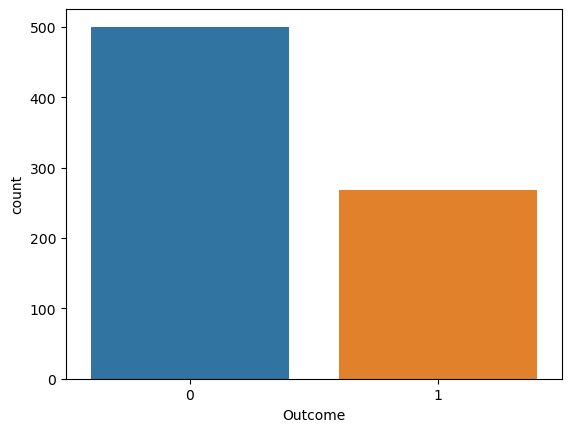

In [10]:
#Summary of Categoricals columns

cat_summary(diabetes, cat_cols, True)

#### 2.2 ) Analysis of Numerical Variables

In [11]:
def num_summary(dataframe, col, groupby=None, log_scale=False, ax=None):
    """
    Plot histogram(s) for a column in a dataframe, optionally grouped by another column.

    Parameters:
    ----------
    dataframe : DataFrame
        The dataframe containing the data to plot.
    col : str
        Name of the column for which to plot the histogram.
    groupby : str or None, optional
        Name of the column by which to group the data. Default is None.
    log_scale : bool, optional
        Whether to use a logarithmic scale on the y-axis. Default is False.
    ax : matplotlib Axes object, optional
        Axes object to plot on. If None, a new figure and axes will be created. Default is None.

    Returns:
    -------
    None
    """
    quantiles = [0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99]
    print(dataframe[col].describe(quantiles).T)

    
    # Set up the figure and axes if not provided
    if ax is None:
        fig, ax = plt.subplots(figsize=(12, 6))
    
    # Set seaborn color palette for colorblind accessibility and distinct colors
    sns.set_palette(sns.color_palette("viridis"))
    
    # Plot histogram with or without grouping
    if groupby is not None:
        sns.histplot(data=dataframe, x=col, bins=20, kde=True, hue=groupby, palette="viridis", ax=ax)
    else:
        sns.histplot(data=dataframe, x=col, bins=20, kde=True, color='mediumpurple', ax=ax)
    
    # Set plot labels and title
    ax.set_title(f'Histogram for {col}', fontsize=16, weight='bold')
    ax.set_xlabel(col, fontsize=14)
    ax.set_ylabel('Frequency', fontsize=14)
    
    # Set y-axis to log scale if log_scale is True
    if log_scale:
        ax.set_yscale('log')
    
    # Enhance grid and ticks for better readability
    ax.grid(True, linestyle='--', linewidth=0.5)
    ax.tick_params(axis='both', labelsize=12)

    # Adjust layout for better spacing
    plt.tight_layout()

# Example usage:
# Assuming df is your DataFrame and col is the column name to plot
# plot_histogram(df, 'col_name', groupby='group_col', log_scale=True)



count   768.000
mean      3.845
std       3.370
min       0.000
5%        0.000
10%       0.000
20%       1.000
30%       1.000
40%       2.000
50%       3.000
60%       4.000
70%       5.000
80%       7.000
90%       9.000
95%      10.000
99%      13.000
max      17.000
Name: Pregnancies, dtype: float64
count   768.000
mean    120.895
std      31.973
min       0.000
5%       79.000
10%      85.000
20%      95.000
30%     102.000
40%     109.000
50%     117.000
60%     125.000
70%     134.000
80%     147.000
90%     167.000
95%     181.000
99%     196.000
max     199.000
Name: Glucose, dtype: float64
count   768.000
mean     69.105
std      19.356
min       0.000
5%       38.700
10%      54.000
20%      60.000
30%      64.000
40%      68.000
50%      72.000
60%      74.000
70%      78.000
80%      82.000
90%      88.000
95%      90.000
99%     106.000
max     122.000
Name: BloodPressure, dtype: float64
count   768.000
mean     20.536
std      15.952
min       0.000
5%        0.000
10% 

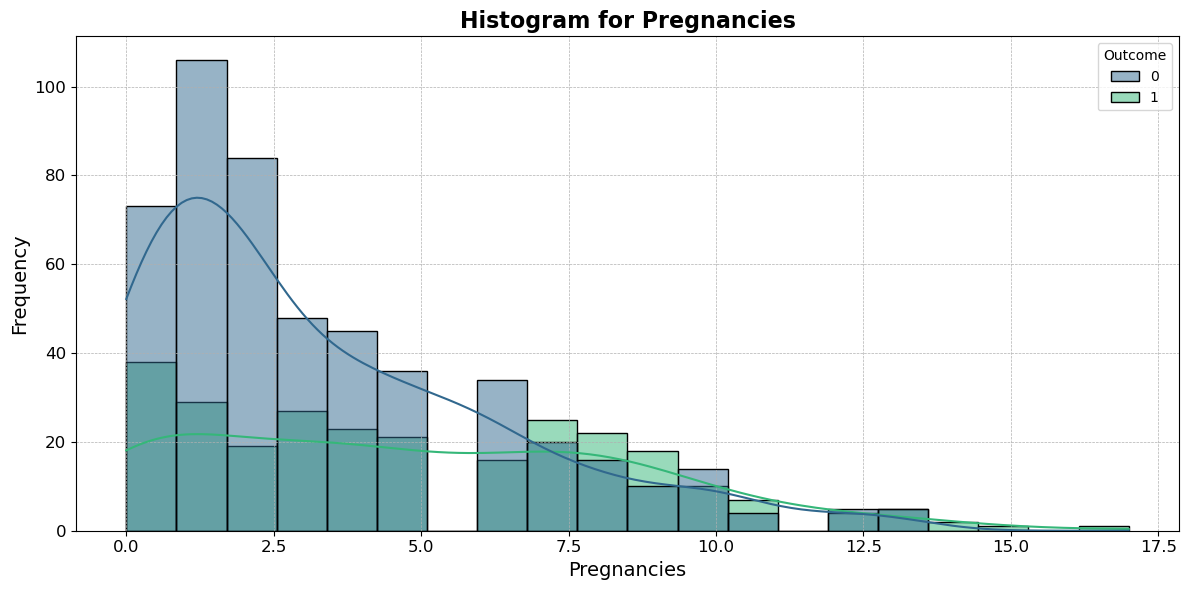

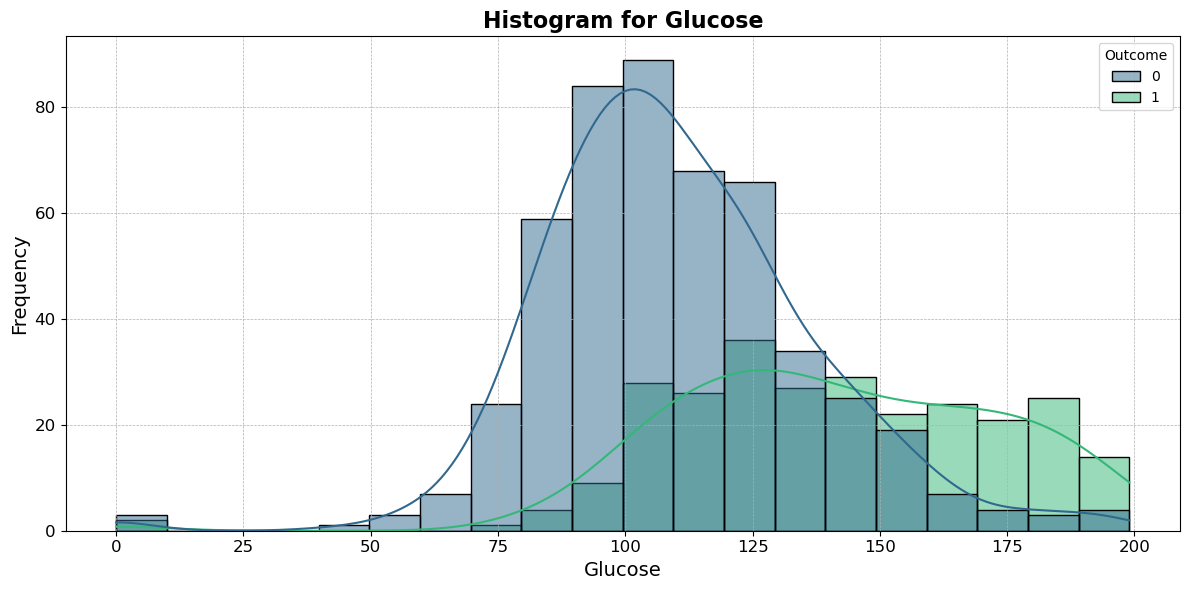

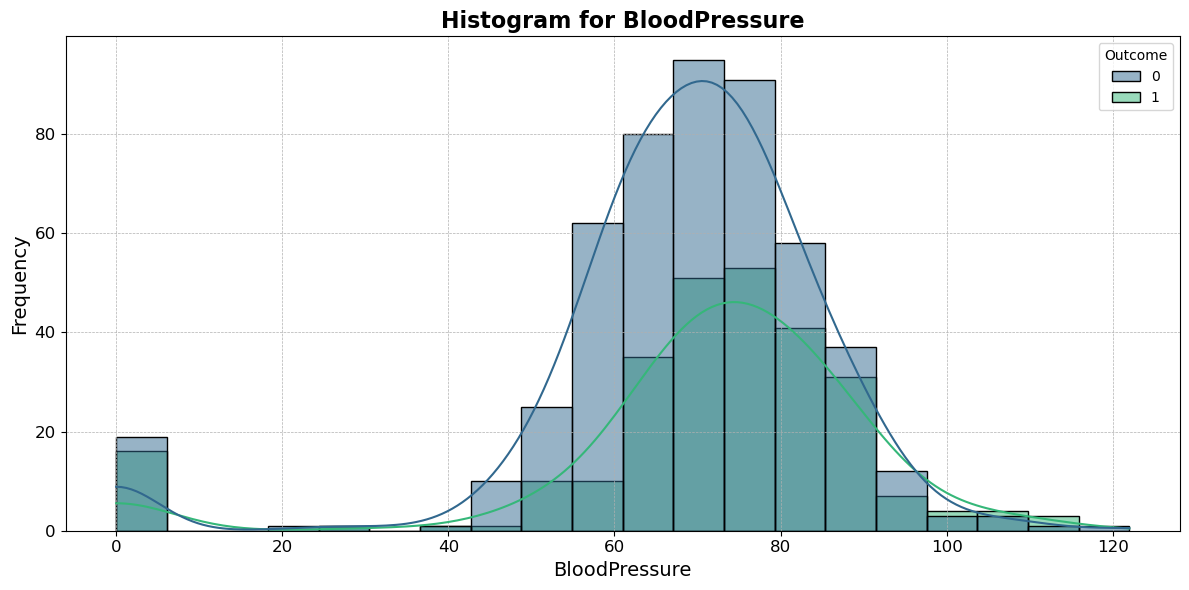

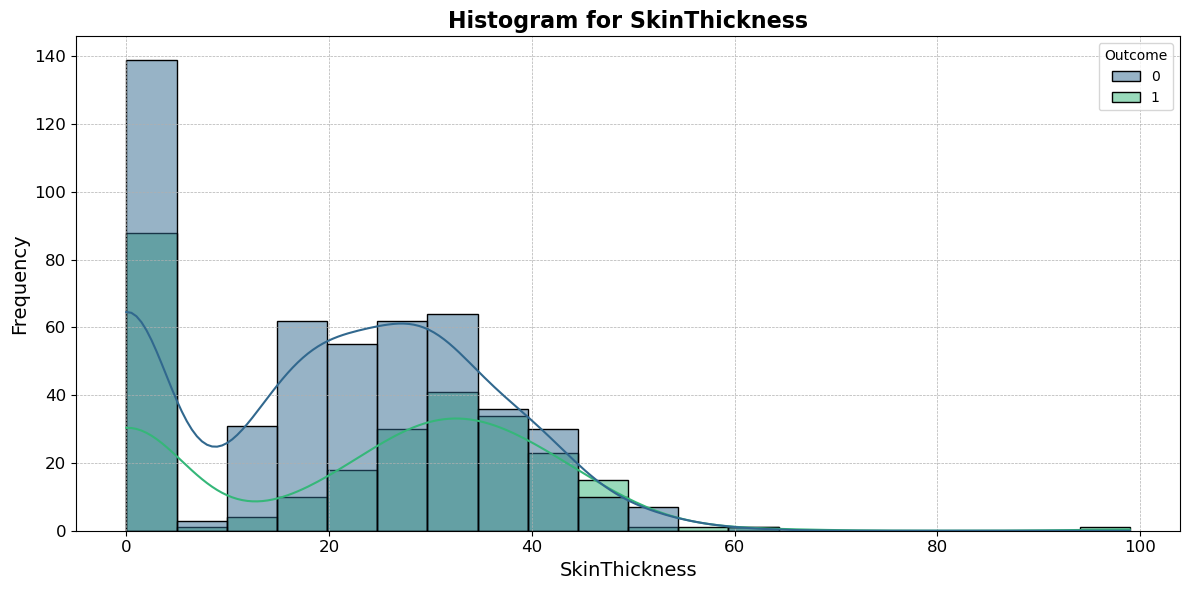

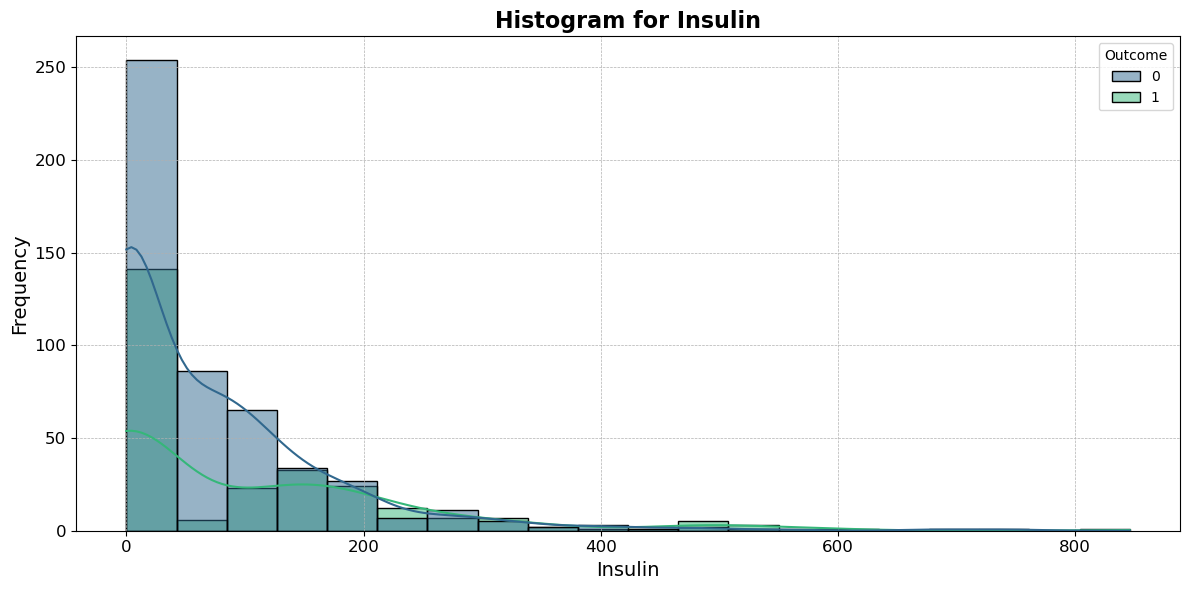

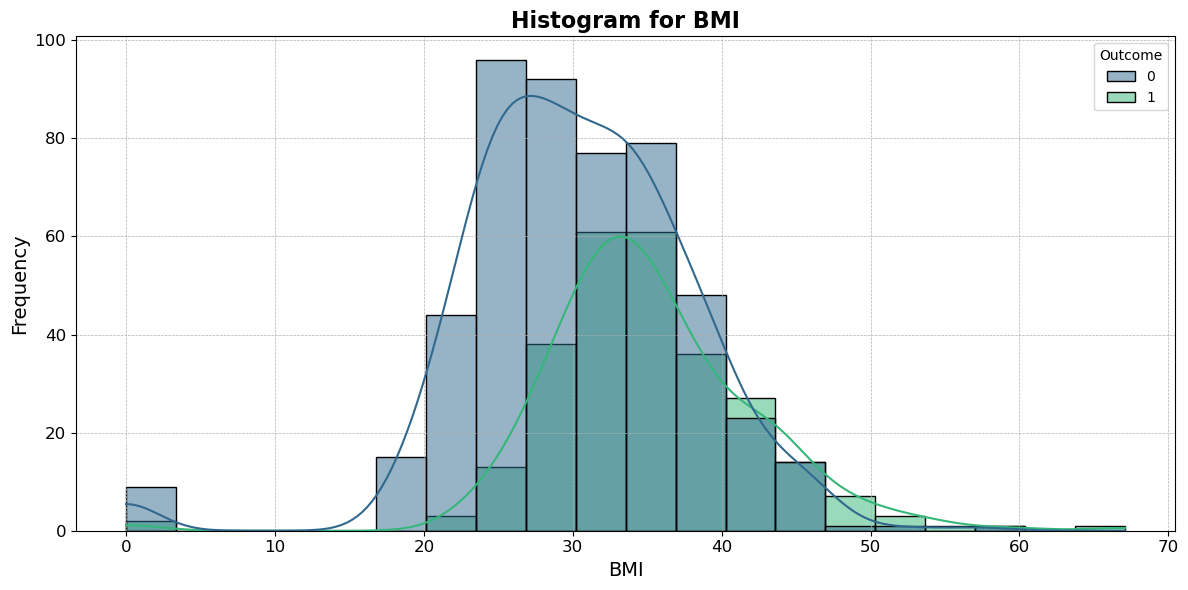

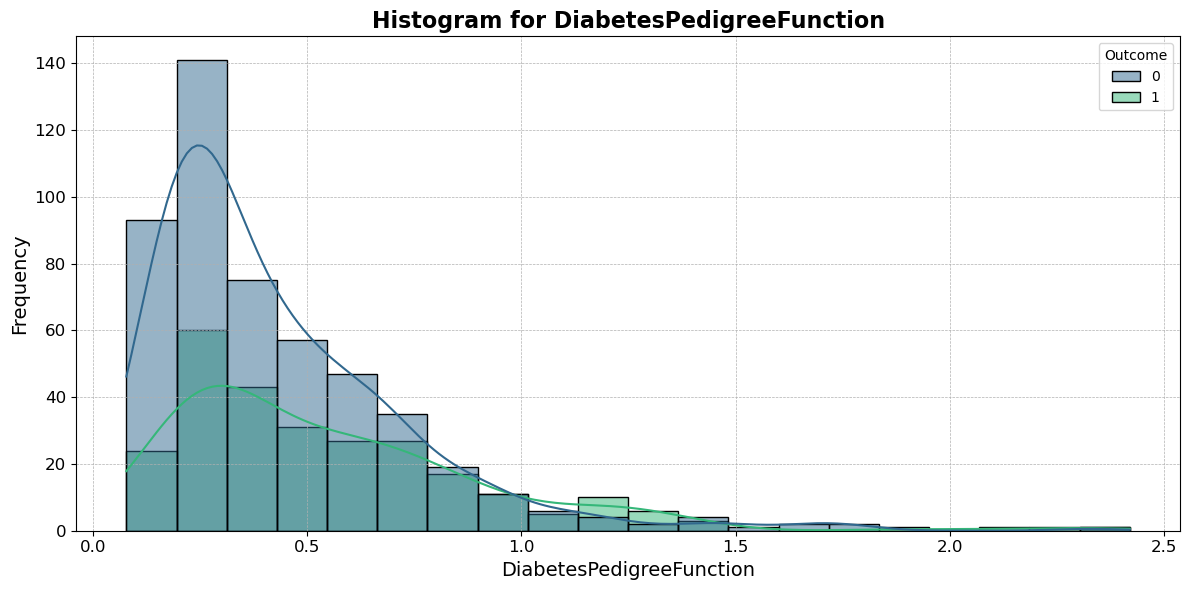

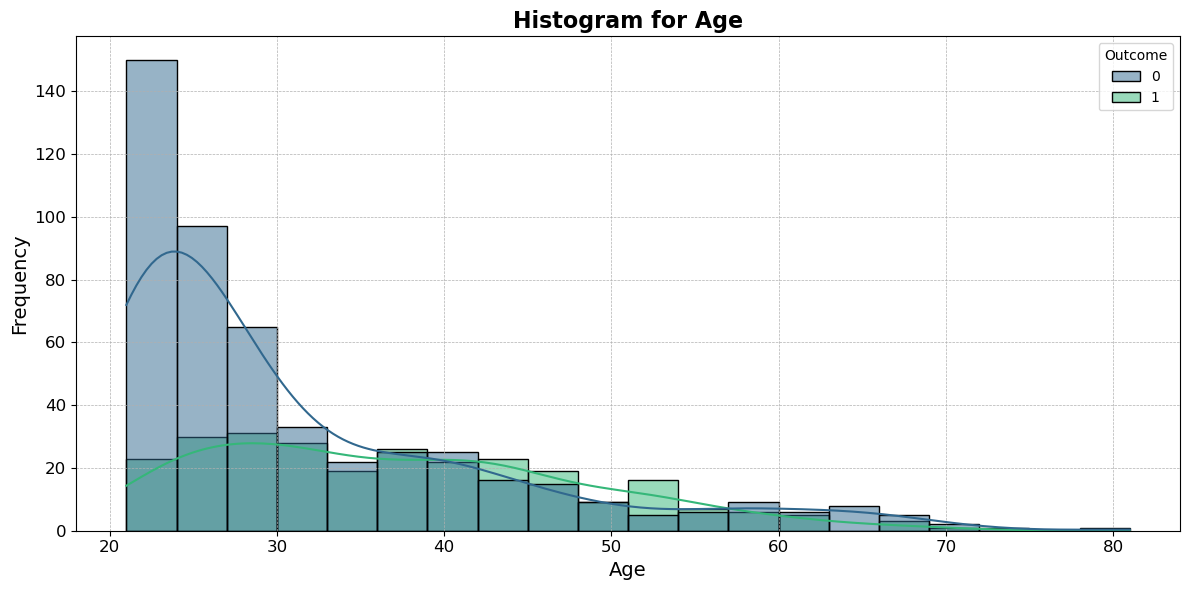

In [12]:
for col in num_cols:
    num_summary(diabetes, col, groupby="Outcome")

**Analysis of Numerical Variables by Target**

In [13]:
 # This function calculates and prints the mean of a numerical column, grouped by the target variable.

def target_summary_with_num(dataframe, target, numerical_col):
    
    # Group the dataframe by the target variable and calculate the mean of the numerical column for each group.
    # The .agg() method is used to apply the mean function to the specified numerical column.
    print(dataframe.groupby(target).agg({numerical_col: "mean"}), end="\n\n\n")

# Iterate over each numerical column in the list of numerical columns.
for col in num_cols:
    # Call the target_summary_with_num function for each numerical column to print the mean values grouped by the target.
    target_summary_with_num(diabetes, "Outcome", col)


         Pregnancies
Outcome             
0              3.298
1              4.866


         Glucose
Outcome         
0        109.980
1        141.257


         BloodPressure
Outcome               
0               68.184
1               70.825


         SkinThickness
Outcome               
0               19.664
1               22.164


         Insulin
Outcome         
0         68.792
1        100.336


           BMI
Outcome       
0       30.304
1       35.143


         DiabetesPedigreeFunction
Outcome                          
0                           0.430
1                           0.550


           Age
Outcome       
0       31.190
1       37.067




#### 2.3 ) CORRELATION

Correlation, in probability theory and statistics, indicates the direction and strength of the linear relationship between two random variables.

In [14]:
diabetes.corr()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
Pregnancies,1.000,0.129,0.141,-0.082,-0.074,0.018,-0.034,0.544,0.222
Glucose,0.129,1.000,0.153,0.057,0.331,0.221,0.137,0.264,0.467
BloodPressure,0.141,0.153,1.000,0.207,0.089,0.282,0.041,0.240,0.065
SkinThickness,-0.082,0.057,0.207,1.000,0.437,0.393,0.184,-0.114,0.075
Insulin,-0.074,0.331,0.089,0.437,1.000,0.198,0.185,-0.042,0.131
BMI,0.018,0.221,0.282,0.393,0.198,1.000,0.141,0.036,0.293
DiabetesPedigreeFunction,-0.034,0.137,0.041,0.184,0.185,0.141,1.000,0.034,0.174
Age,0.544,0.264,0.240,-0.114,-0.042,0.036,0.034,1.000,0.238
Outcome,0.222,0.467,0.065,0.075,0.131,0.293,0.174,0.238,1.000


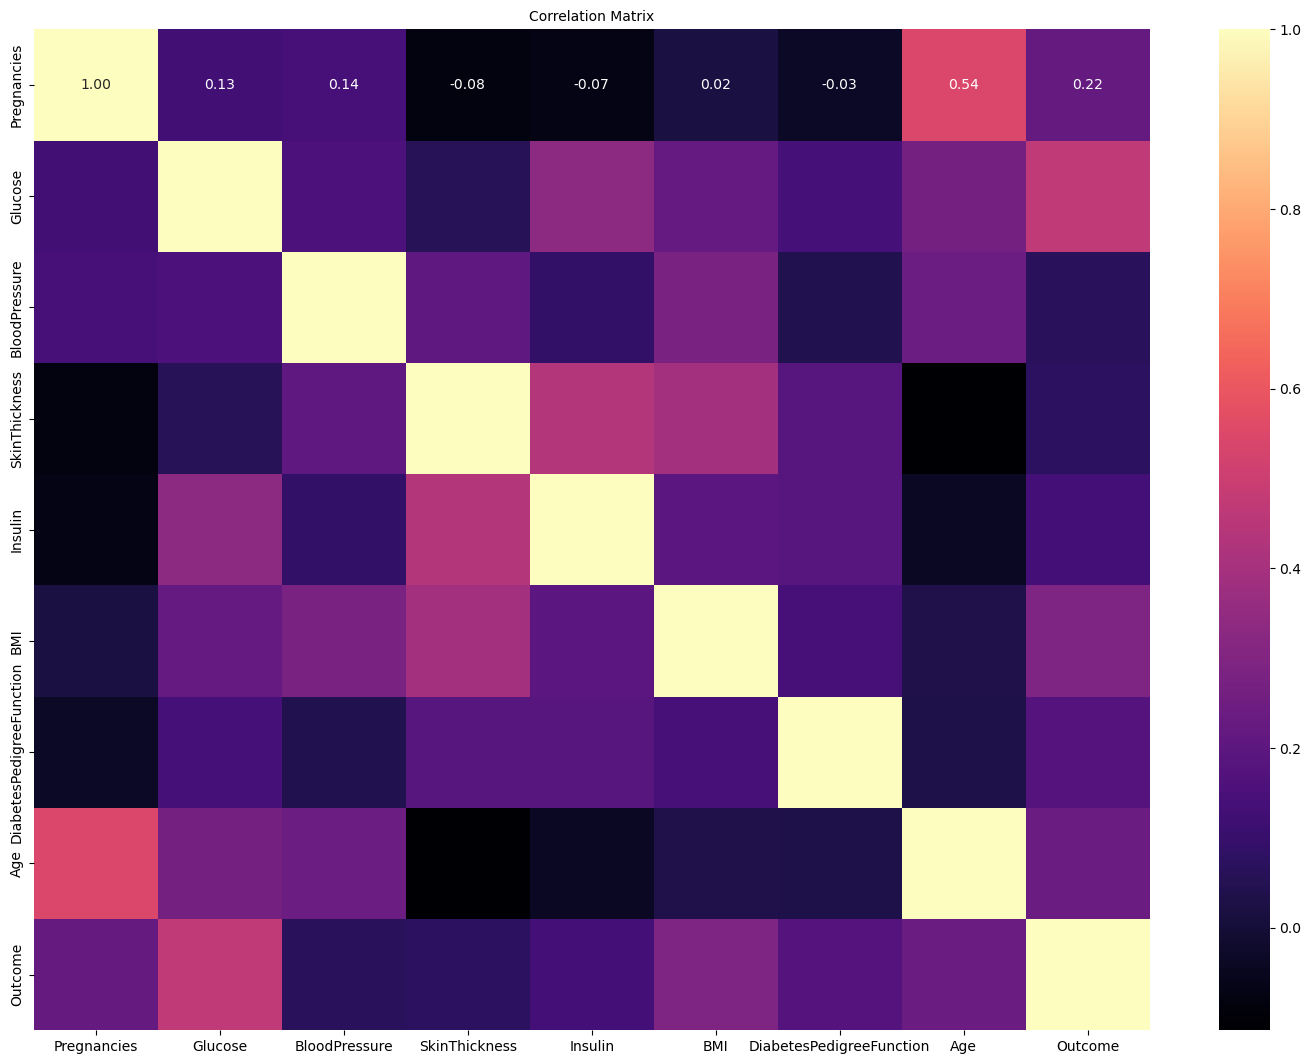

In [15]:
# Correlation Matrix

f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(diabetes.corr(), annot=True, fmt=".2f", ax=ax, cmap="magma")
ax.set_title("Correlation Matrix", fontsize=10)
plt.show()

In [16]:
## Purpose of code is to visually compare the relationship between age and insulin levels for healthy and diabetic individuals using a scatter plot.

# Separate the data into diabetic and healthy individuals based on the 'Outcome' column

diabetic = diabetes[diabetes.Outcome == 1]

healthy = diabetes[diabetes.Outcome == 0]

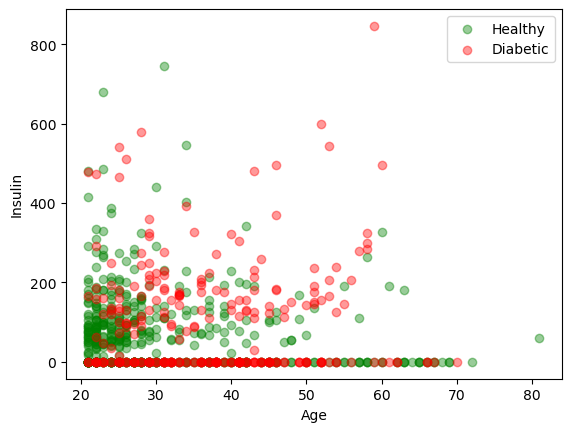

In [17]:
# Plot a scatter plot for healthy and diabetic individuals

plt.scatter(healthy.Age, healthy.Insulin, color="green", label="Healthy", alpha = 0.4)
plt.scatter(diabetic.Age, diabetic.Insulin, color="red", label="Diabetic", alpha = 0.4)
plt.xlabel("Age")
plt.ylabel("Insulin")
plt.legend()
plt.show()

In [18]:
## Base Model Setup

##Separating the target variable (y) from the features (X):

# - y is assigned the values of the "Outcome" column from the dataframe df. This represents the target variable we want to predict (whether an individual is diabetic or not).
# - X is assigned the dataframe df with the "Outcome" column removed. This contains all the features used to make the prediction.

y = diabetes["Outcome"]
X = diabetes.drop("Outcome", axis=1)

## Splitting the dataset into training and testing sets:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=17)

## Training a Random Forest model:

rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)

## Making predictions on the test set:

y_pred = rf_model.predict(X_test)

print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.77
Recall: 0.706
Precision: 0.59
F1: 0.64
Auc: 0.75


## 3. Data Cleaning and Preprocessing

#### 3.1 )Missing Values 

In [19]:
diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

There are no missing observations in the dataset, but observations with a value of 0 in variables such as Glucose, Insulin, etc., might indicate missing values. For example, a person's glucose or insulin level cannot be 0. Considering this, we can replace zero values in these relevant variables with NaN, and then apply missing value handling techniques.

In [20]:
# Identify columns in the DataFrame 'df' where zero values might indicate missing data
# Exclude the "Pregnancies" and "Outcome" columns from this identification

zero_columns = [col for col in diabetes.columns if (diabetes[col].min() == 0 and col not in ["Pregnancies", "Outcome"])]

In [21]:
# Iterate over each column identified as potentially having zero values indicating missing data

for col in zero_columns:
    # Replace zero values with NaN in the current column
    diabetes[col].replace(0, np.nan, inplace=True)

##Another way 
# for col in zero_columns:
#    diabetes[col] = np.where(diabetes[col] == 0, np.nan, df[col])

In [22]:
diabetes.isnull().sum()

Pregnancies                   0
Glucose                       5
BloodPressure                35
SkinThickness               227
Insulin                     374
BMI                          11
DiabetesPedigreeFunction      0
Age                           0
Outcome                       0
dtype: int64

In [23]:
def missing_values_table(dataframe, na_name=False):
    # Identify columns with missing values
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    
    # Calculate the number of missing values in each column
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    
    # Calculate the percentage of missing values in each column
    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)
    
    # Combine the number of missing values and their ratios into a DataFrame
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    
    # Print the DataFrame showing the count and percentage of missing values
    print(missing_df, end="\n")
    
    # If na_name is True, return the list of columns with missing values
    if na_name:
        return na_columns


#### 3.1.1 Analyzing of missing values

In [24]:
na_columns = missing_values_table(diabetes, na_name=True)

               n_miss  ratio
Insulin           374 48.700
SkinThickness     227 29.560
BloodPressure      35  4.560
BMI                11  1.430
Glucose             5  0.650


#### 3.1.2 Filling Missing Values

This section of the analysis focuses on handling and filling in missing values within the dataset to ensure data integrity and accuracy in subsequent modeling efforts.

In [25]:
zero_columns

['Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

In [26]:
# Loop over each column name in the zero_columns list
for col in zero_columns:
    # In the 'diabetes' DataFrame, locate the rows where the column 'col' has NaN (missing) values.
    # Replace these NaN values with the median of the same column.
    
    diabetes.loc[diabetes[col].isnull(), col] = diabetes[col].median()


In [27]:
diabetes.isnull().sum()

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64

#### 3.2 )Outliers

In [28]:
# The outlier_thresholds function is used to calculate the lower and upper limits for identifying outliers in a 
# specified column of a pandas DataFrame based on the interquartile range (IQR) method. 

def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

# The check_outlier function is designed to determine whether there are any outliers in a specified column of a pandas DataFrame.
def check_outlier(dataframe, col_name):
    # Calculate the lower and upper limits for outliers in the specified column using the outlier_thresholds function
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    # Check if there are any values in the specified column that are outside the calculated limits
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    # If there is at least one value outside the limits, return True
    else:
    # If there are no values outside the limits, return False
        return False

def replace_with_thresholds(dataframe, variable, q1=0.05, q3=0.95):
    # Calculate the lower and upper limits for outliers in the specified variable using the outlier_thresholds function with the given quantiles (q1 and q3)
    low_limit, up_limit = outlier_thresholds(dataframe, variable, q1=0.05, q3=0.95)
    # Replace values in the specified variable that are below the lower limit with the lower limit
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [29]:
for col in num_cols:
    print(col,check_outlier(diabetes,col))
    

Pregnancies False
Glucose False
BloodPressure False
SkinThickness True
Insulin True
BMI False
DiabetesPedigreeFunction False
Age False


In [30]:
for col in num_cols:
    replace_with_thresholds(diabetes,col)
    
    

In [31]:
for col in num_cols:
    print(col,check_outlier(diabetes,col))

Pregnancies False
Glucose False
BloodPressure False
SkinThickness False
Insulin False
BMI False
DiabetesPedigreeFunction False
Age False


#### 3.3 )Feature Engineering

In [32]:
# # Categorizing the age variable and creating a new age variable

diabetes.loc[(diabetes["Age"] >= 21) & (diabetes["Age"] < 50), "NEW_AGE_CAT"] = "mature"
diabetes.loc[(diabetes["Age"] >= 50), "NEW_AGE_CAT"] = "senior"

In [33]:
# Categorize the BMI variables

diabetes['NEW_BMI'] = pd.cut(x=diabetes['BMI'], bins=[0, 18.5, 24.9, 29.9, 100],labels=["Underweight", "Healthy", "Overweight", "Obese"])

In [34]:
# Converting the glucose value into a categorical variable

diabetes["NEW_GLUCOSE"] = pd.cut(x=diabetes["Glucose"], bins=[0, 140, 200, 300], labels=["Normal", "Prediabetes", "Diabetes"])

In [35]:
# # Creating a categorical variable by considering age and body mass index together

diabetes.loc[(diabetes["BMI"] < 18.5) & ((diabetes["Age"] >= 21) & (diabetes["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "under_weight_mature"
diabetes.loc[(diabetes["BMI"] < 18.5) & (diabetes["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "under_weight_senior"
diabetes.loc[((diabetes["BMI"] >= 18.5) & (diabetes["BMI"] < 25)) & ((diabetes["Age"] >= 21) & (diabetes["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "healthy_mature"
diabetes.loc[((diabetes["BMI"] >= 18.5) & (diabetes["BMI"] < 25)) & (diabetes["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "healthy_senior"
diabetes.loc[((diabetes["BMI"] >= 25) & (diabetes["BMI"] < 30)) & ((diabetes["Age"] >= 21) & (diabetes["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "over_weight_mature"
diabetes.loc[((diabetes["BMI"] >= 25) & (diabetes["BMI"] < 30)) & (diabetes["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "over_weight_senior"
diabetes.loc[(diabetes["BMI"] > 18.5) & ((diabetes["Age"] >= 21) & (diabetes["Age"] < 50)), "NEW_AGE_BMI_NOM"] = "obese_mature"
diabetes.loc[(diabetes["BMI"] > 18.5) & (diabetes["Age"] >= 50), "NEW_AGE_BMI_NOM"] = "obese_senior"

In [37]:
# Creating a categorical variable by considering age and glucose values together

diabetes.loc[(diabetes["Glucose"] < 70) & ((diabetes["Age"] >= 21) & (diabetes["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "low_mature"
diabetes.loc[(diabetes["Glucose"] < 70) & (diabetes["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "low_senior"
diabetes.loc[((diabetes["Glucose"] >= 70) & (diabetes["Glucose"] < 100)) & ((diabetes["Age"] >= 21) & (diabetes["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "normal_mature"
diabetes.loc[((diabetes["Glucose"] >= 70) & (diabetes["Glucose"] < 100)) & (diabetes["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "normal_senior"
diabetes.loc[((diabetes["Glucose"] >= 100) & (diabetes["Glucose"] <= 125)) & ((diabetes["Age"] >= 21) & (diabetes["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "hidden_mature"
diabetes.loc[((diabetes["Glucose"] >= 100) & (diabetes["Glucose"] <= 125)) & (diabetes["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "hidden_senior"
diabetes.loc[(diabetes["Glucose"] > 125) & ((diabetes["Age"] >= 21) & (diabetes["Age"] < 50)), "NEW_AGE_GLUCOSE_NOM"] = "high_mature"
diabetes.loc[(diabetes["Glucose"] > 125) & (diabetes["Age"] >= 50), "NEW_AGE_GLUCOSE_NOM"] = "high_senior"

In [38]:
# Deriving a categorical variable from insulin value

def set_insulin(dataframe, col_name="Insulin"):
    if 16 <= dataframe[col_name] <= 166:
        return "Normal"
    else:
        return "Abnormal"

diabetes["NEW_INSULIN_SCORE"] = diabetes.apply(set_insulin, axis=1)

diabetes["NEW_GLUCOSE*INSULIN"] = diabetes["Glucose"] * diabetes["Insulin"]

diabetes["NEW_GLUCOSE*PREGNANCIES"] = diabetes["Glucose"] * diabetes["Pregnancies"]

In [40]:
# # Converting variable names to uppercase

diabetes.columns = [col.upper() for col in diabetes.columns]
diabetes.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,senior,Obese,Prediabetes,obese_senior,high_senior,Normal,18500.000,888.000
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,mature,Overweight,Normal,obese_mature,normal_mature,Normal,10625.000,85.000
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,mature,Healthy,Prediabetes,obese_mature,high_mature,Normal,22875.000,1464.000
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,mature,Overweight,Normal,obese_mature,normal_mature,Normal,8366.000,89.000
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1,mature,Obese,Normal,obese_mature,high_mature,Abnormal,23016.000,0.000


In [43]:
## NEW_GLUCOSE*PREGNANCIES has ZERO values..

diabetes["NEW_GLUCOSE*PREGNANCIES"] = diabetes["GLUCOSE"] * (1+ diabetes["PREGNANCIES"])

In [45]:
# Creating a new categorical variable 'PregnancyGroup' based on 'Pregnancies' column

diabetes['PREGNANCIES_GROUP'] = pd.cut(diabetes['PREGNANCIES'],
                                    bins=[diabetes['PREGNANCIES'].min(), 1, 2, 3, 5, float('inf')],
                                    labels=['None', '1', '2', '3-4', '5+'],
                                    include_lowest=True)
diabetes.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,PREGNANCIES_GROUP
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,senior,Obese,Prediabetes,obese_senior,high_senior,Normal,18500.000,1036.000,5+
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,mature,Overweight,Normal,obese_mature,normal_mature,Normal,10625.000,170.000,None
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,mature,Healthy,Prediabetes,obese_mature,high_mature,Normal,22875.000,1647.000,5+
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,mature,Overweight,Normal,obese_mature,normal_mature,Normal,8366.000,178.000,None
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1,mature,Obese,Normal,obese_mature,high_mature,Abnormal,23016.000,137.000,None


#### 4.)ENCODING

In [46]:
# Separating the newly created features by variable types
# Before dataset number of variables
#Observations: 768
#Variables: 9
#cat_cols: 1
#num_cols: 8
#cat_but_car: 0
#num_but_cat: 1


cat_cols, num_cols, cat_but_car = grab_col_names(diabetes)

Observations: 768
Variables: 18
cat_cols: 8
num_cols: 10
cat_but_car: 0
num_but_cat: 4


In [47]:
cat_cols

['NEW_AGE_CAT',
 'NEW_AGE_BMI_NOM',
 'NEW_AGE_GLUCOSE_NOM',
 'NEW_INSULIN_SCORE',
 'OUTCOME',
 'NEW_BMI',
 'NEW_GLUCOSE',
 'PREGNANCIES_GROUP']

In [48]:
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE',
 'NEW_GLUCOSE*INSULIN',
 'NEW_GLUCOSE*PREGNANCIES']

#### 4.1 )LABEL ENCODING

In [49]:
# Initialize the LabelEncoder

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in diabetes.columns if diabetes[col].dtypes == "O" and diabetes[col].nunique() == 2]
binary_cols

for col in binary_cols:
    diabetes = label_encoder(diabetes, col)

In [50]:
diabetes.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_BMI,NEW_GLUCOSE,NEW_AGE_BMI_NOM,NEW_AGE_GLUCOSE_NOM,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,PREGNANCIES_GROUP
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,1,Obese,Prediabetes,obese_senior,high_senior,1,18500.000,1036.000,5+
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,0,Overweight,Normal,obese_mature,normal_mature,1,10625.000,170.000,None
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,0,Healthy,Prediabetes,obese_mature,high_mature,1,22875.000,1647.000,5+
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,0,Overweight,Normal,obese_mature,normal_mature,1,8366.000,178.000,None
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1,0,Obese,Normal,obese_mature,high_mature,0,23016.000,137.000,None


#### 4.2 ) One-Hot Encoding İşlemi

In [51]:
# Remove target column

## Updating cat_cols

cat_cols = [col for col in cat_cols if col not in binary_cols and col not in ["OUTCOME"]]

cat_cols

['NEW_AGE_BMI_NOM',
 'NEW_AGE_GLUCOSE_NOM',
 'NEW_BMI',
 'NEW_GLUCOSE',
 'PREGNANCIES_GROUP']

In [52]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

diabetes = one_hot_encoder(diabetes, cat_cols, drop_first=True)

diabetes.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obese_senior,NEW_AGE_BMI_NOM_under_weight_mature,NEW_AGE_GLUCOSE_NOM_hidden_senior,NEW_AGE_GLUCOSE_NOM_high_mature,NEW_AGE_GLUCOSE_NOM_high_senior,NEW_AGE_GLUCOSE_NOM_low_mature,NEW_AGE_GLUCOSE_NOM_low_senior,NEW_AGE_GLUCOSE_NOM_normal_mature,NEW_AGE_GLUCOSE_NOM_normal_senior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes,PREGNANCIES_GROUP_1,PREGNANCIES_GROUP_2,PREGNANCIES_GROUP_3-4,PREGNANCIES_GROUP_5+
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,1,1,18500.000,1036.000,True,False,False,False,True,False,False,False,False,False,False,True,True,False,False,False,False,True
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,0,1,10625.000,170.000,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,0,1,22875.000,1647.000,False,False,False,True,False,False,False,False,False,True,False,False,True,False,False,False,False,True
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,0,1,8366.000,178.000,False,False,False,False,False,False,False,True,False,False,True,False,False,False,False,False,False,False
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1,0,0,23016.000,137.000,False,False,False,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False


In [56]:
diabetes = diabetes.applymap(lambda x: 1 if x is True else 0 if x is False else x)

diabetes.head()

,PREGNANCIES,GLUCOSE,BLOODPRESSURE,SKINTHICKNESS,INSULIN,BMI,DIABETESPEDIGREEFUNCTION,AGE,OUTCOME,NEW_AGE_CAT,NEW_INSULIN_SCORE,NEW_GLUCOSE*INSULIN,NEW_GLUCOSE*PREGNANCIES,NEW_AGE_BMI_NOM_obese_senior,NEW_AGE_BMI_NOM_under_weight_mature,NEW_AGE_GLUCOSE_NOM_hidden_senior,NEW_AGE_GLUCOSE_NOM_high_mature,NEW_AGE_GLUCOSE_NOM_high_senior,NEW_AGE_GLUCOSE_NOM_low_mature,NEW_AGE_GLUCOSE_NOM_low_senior,NEW_AGE_GLUCOSE_NOM_normal_mature,NEW_AGE_GLUCOSE_NOM_normal_senior,NEW_BMI_Healthy,NEW_BMI_Overweight,NEW_BMI_Obese,NEW_GLUCOSE_Prediabetes,NEW_GLUCOSE_Diabetes,PREGNANCIES_GROUP_1,PREGNANCIES_GROUP_2,PREGNANCIES_GROUP_3-4,PREGNANCIES_GROUP_5+
0,6,148.000,72.000,35.000,125.000,33.600,0.627,50.000,1,1,1,18500.000,1036.000,1,0,0,0,1,0,0,0,0,0,0,1,1,0,0,0,0,1
1,1,85.000,66.000,29.000,125.000,26.600,0.351,31.000,0,0,1,10625.000,170.000,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
2,8,183.000,64.000,29.000,125.000,23.300,0.672,32.000,1,0,1,22875.000,1647.000,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,1
3,1,89.000,66.000,23.000,94.000,28.100,0.167,21.000,0,0,1,8366.000,178.000,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0
4,0,137.000,40.000,35.000,168.000,43.100,2.288,33.000,1,0,0,23016.000,137.000,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0


#### 4.3 ) Scaling

In [57]:
num_cols

['PREGNANCIES',
 'GLUCOSE',
 'BLOODPRESSURE',
 'SKINTHICKNESS',
 'INSULIN',
 'BMI',
 'DIABETESPEDIGREEFUNCTION',
 'AGE',
 'NEW_GLUCOSE*INSULIN',
 'NEW_GLUCOSE*PREGNANCIES']

In [58]:
scaler = StandardScaler()

diabetes[num_cols] = scaler.fit_transform(diabetes[num_cols])

#### 5.)MODELLING

In [60]:
# Isolated the response variable and the predictor variables

y = diabetes["OUTCOME"]
X = diabetes.drop("OUTCOME", axis=1)

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=49)

# Initialize the model and training the model
rf_model = RandomForestClassifier(random_state=46).fit(X_train, y_train)

# Make predictions
y_pred = rf_model.predict(X_test)


#### 6.) RESULT

In [61]:
print(f"Accuracy: {round(accuracy_score(y_pred, y_test), 2)}")
print(f"Recall: {round(recall_score(y_pred,y_test),3)}")
print(f"Precision: {round(precision_score(y_pred,y_test), 2)}")
print(f"F1: {round(f1_score(y_pred,y_test), 2)}")
print(f"Auc: {round(roc_auc_score(y_pred,y_test), 2)}")

Accuracy: 0.75
Recall: 0.739
Precision: 0.56
F1: 0.64
Auc: 0.75


    Value                              Feature
1   0.133                              GLUCOSE
10  0.119                  NEW_GLUCOSE*INSULIN
5   0.103                                  BMI
11  0.094              NEW_GLUCOSE*PREGNANCIES
7   0.093                                  AGE
..    ...                                  ...
17  0.001       NEW_AGE_GLUCOSE_NOM_low_mature
20  0.001    NEW_AGE_GLUCOSE_NOM_normal_senior
18  0.000       NEW_AGE_GLUCOSE_NOM_low_senior
13  0.000  NEW_AGE_BMI_NOM_under_weight_mature
25  0.000                 NEW_GLUCOSE_Diabetes

[30 rows x 2 columns]


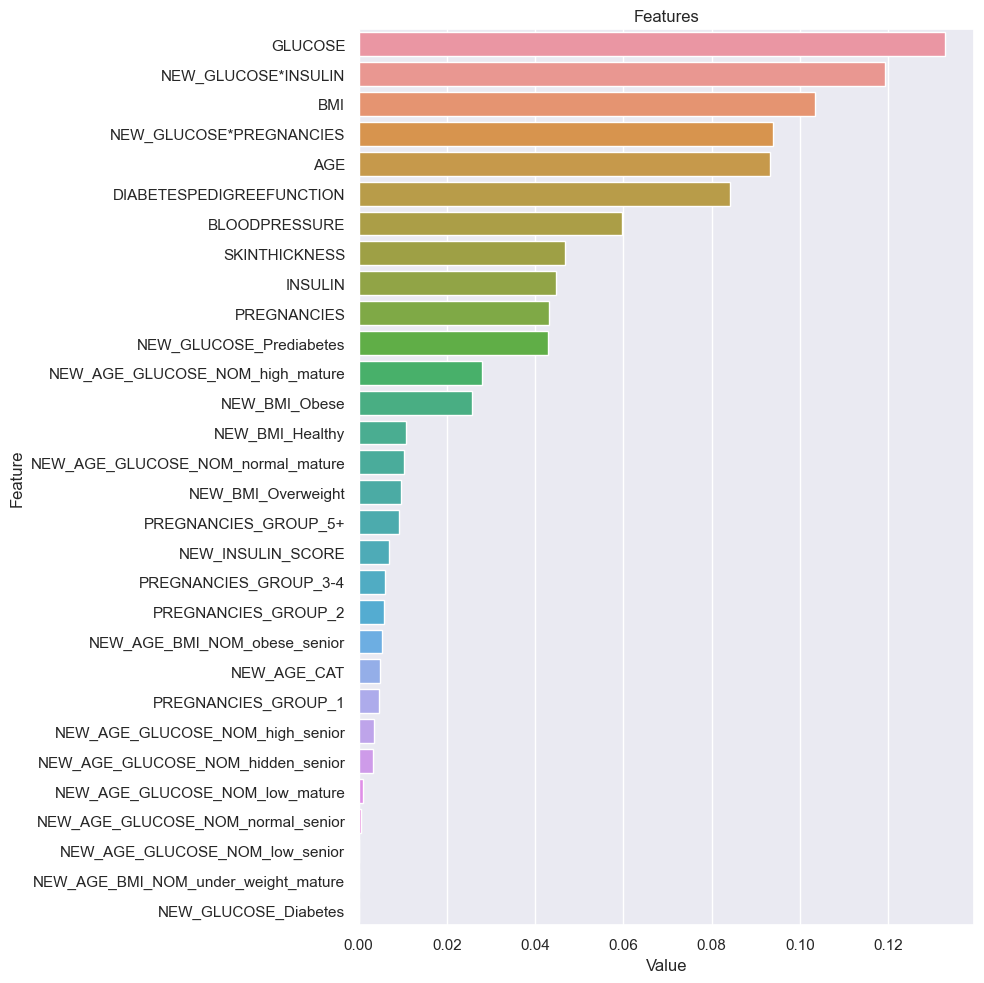

In [62]:
# Visualize feature importances 

def plot_importance(model, features, num=len(X), save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    print(feature_imp.sort_values("Value",ascending=False))
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig('importances.png')

plot_importance(rf_model, X)